Save a subset of the MNIST data, so that embeddings can be viewed with TensorBoard.

Based on code by Roland Meertens

View by running
tensorboard --logdir=embedding_data_notmnist

In [1]:
# Based on code from:
# https://www.pinchofintelligence.com/simple-introduction-to-tensorboard-embedding-visualisation/
# Roland Meertens

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

from __future__ import print_function
from six.moves import cPickle as pickle
from six.moves import range

from tensorflow.contrib.tensorboard.plugins import projector
# from tensorflow.examples.tutorials.mnist import input_data

LOG_DIR = 'embedding_data_notmnist'
NAME_TO_VISUALISE_VARIABLE = "notmnistembedding"
TO_EMBED_COUNT = 2000

path_for_sprites =  os.path.join(LOG_DIR,'chars.png')
path_for_metadata =  os.path.join(LOG_DIR,'metadata.tsv')

In [2]:
image_size = 28
data_root = os.path.join('.', 'notMNIST_data') # Change me to store data elsewhere
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)
    
def reformat_vec(dataset):
    dataset = dataset.reshape(
        (-1, image_size*image_size)).astype(np.float32)
    return dataset
train_dataset_vec = reformat_vec(train_dataset)
valid_dataset_vec = reformat_vec(valid_dataset)
test_dataset_vec = reformat_vec(test_dataset)
print('Training set', train_dataset_vec.shape, train_labels.shape)
print('Validation set', valid_dataset_vec.shape, valid_labels.shape)
print('Test set', test_dataset_vec.shape, test_labels.shape)

batch_xs = valid_dataset_vec[:TO_EMBED_COUNT, :]
batch_ys = valid_labels[:TO_EMBED_COUNT]

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)
Training set (200000, 784) (200000,)
Validation set (10000, 784) (10000,)
Test set (10000, 784) (10000,)


In [3]:
# TODO: Update labels so that they include a "misclassified" label (10)
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

save_dir = os.path.join('notmnist_current_model', 'save')

def reformat_tens(dataset, labels):
    dataset = dataset.reshape(
        (-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset_tens, train_labels_tens = reformat_tens(train_dataset, train_labels)
valid_dataset_tens, valid_labels_tens = reformat_tens(valid_dataset, valid_labels)
test_dataset_tens, test_labels_tens = reformat_tens(test_dataset, test_labels)
print('Training set', train_dataset_tens.shape, train_labels_tens.shape)
print('Validation set', valid_dataset_tens.shape, valid_labels_tens.shape)
print('Test set', test_dataset_tens.shape, test_labels_tens.shape)

new_graph = tf.Graph()
with tf.Session(graph=new_graph) as sess:
    # Import the previously export meta graph.
    saver = tf.train.import_meta_graph(save_dir + '/model.meta')
    saver.restore(sess, save_dir + '/model')
    print('Model restored.')
    graph = tf.get_default_graph()
    correct_prediction = graph.get_tensor_by_name('accuracy/correct_prediction/Equal:0')
    accuracy = graph.get_tensor_by_name('accuracy/accuracy/Mean:0')
    
    correct_valid, accuracy_valid = sess.run([correct_prediction, accuracy], feed_dict={'input/input_data:0': valid_dataset_tens,
                                            'input/input_labels:0': valid_labels_tens, 'dropout/Placeholder:0' : 1.0})
    print('valid accuracy %g' % accuracy_valid)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)
INFO:tensorflow:Restoring parameters from notmnist_current_model/save/model
Model restored.
valid accuracy 0.8947


In [4]:
valid_labels_new = np.argmax(valid_labels_tens, axis=1)
valid_labels_new[np.logical_not(correct_valid)] = 10
print(valid_labels_new.shape)
print(sum(valid_labels_new == 10))

batch_ys = valid_labels_new[:TO_EMBED_COUNT]

(10000,)
1053


In [5]:
embedding_var = tf.Variable(batch_xs, name=NAME_TO_VISUALISE_VARIABLE)
summary_writer = tf.summary.FileWriter(LOG_DIR)

In [6]:
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# Specify where you find the metadata
embedding.metadata_path = path_for_metadata #'metadata.tsv'

# Specify where you find the sprite (we will create this later)
embedding.sprite.image_path = path_for_sprites #'mnistdigits.png'
embedding.sprite.single_image_dim.extend([28,28])

# Say that you want to visualise the embeddings
projector.visualize_embeddings(summary_writer, config)

In [7]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), 1)

'embedding_data_notmnist/model.ckpt-1'

In [8]:
def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    
    
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = this_img
    
    return spriteimage

def vector_to_matrix_notmnist(notmnist_digits):
    """Reshapes normal notmnist digit (batch,28*28) to matrix (batch,28,28)"""
    return np.reshape(notmnist_digits,(-1,28,28))

def invert_grayscale(notmnist_digits):
    """ Makes black white, and white black """
    return 1-notmnist_digits

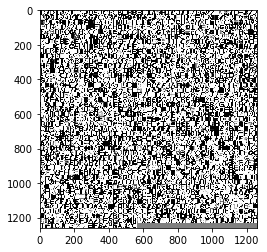

In [9]:
to_visualise = batch_xs
to_visualise = vector_to_matrix_notmnist(to_visualise)
to_visualise = invert_grayscale(to_visualise)

sprite_image = create_sprite_image(to_visualise)

plt.imsave(path_for_sprites,sprite_image,cmap='gray')
plt.imshow(sprite_image,cmap='gray')

In [10]:
with open(path_for_metadata,'w') as f:
    f.write("Index\tLabel\n")
    for index,label in enumerate(batch_ys):
        f.write("%d\t%d\n" % (index,label))